In [1]:
# STANDARD LIBRARY IMPORTS
from calendar import monthrange

# THIRD-PARTY IMPORTS
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ---------- LOAD DATA ----------

budgets = pd.read_csv("budgets_test1.csv")
transactions = pd.read_csv("transactions_test1.csv")

# PARSE DATES
transactions["transaction_date"] = pd.to_datetime(transactions["transaction_date"])

# MERGE DATA
data = pd.merge(
    transactions,
    budgets,
    on=["budget_id", "user_id", "category_id"],
    suffixes=("", "_budget")
)

# SORT DATA BY DATA
data = data.sort_values(["budget_id", "transaction_date"])

# CALCULATE CUMULATIVE SPENDING PER BUDGET
data["cumulative_spent"] = data.groupby("budget_id")["amount"].cumsum()

print("Columns in data:", data.columns.tolist())
print("\nFirst few rows:")
print(data.head())

Columns in data: ['transaction_id', 'budget_id', 'user_id', 'category_id', 'amount', 'transaction_date', 'amount_budget', 'month', 'timeframe', 'cumulative_spent']

First few rows:
   transaction_id  budget_id  user_id  category_id  amount transaction_date  \
0               1          1        1            1    48.3       2025-10-02   
1               2          1        1            1    65.7       2025-10-08   
2               3          1        1            1    72.9       2025-10-15   
3               4          1        1            1    58.4       2025-10-22   
4               5          2        1            2   132.5       2025-10-04   

   amount_budget    month timeframe  cumulative_spent  
0            300  2025-10   monthly              48.3  
1            300  2025-10   monthly             114.0  
2            300  2025-10   monthly             186.9  
3            300  2025-10   monthly             245.3  
4            500  2025-10   monthly             132.5  


In [3]:
# ---------- FORECAST FUNCTION ----------
def forecast_budget(budget_id, timeframe="monthly", plot=True):
    """
    Predicts end-of-time-frame based on linear regression of cumulative spending.
    """
    df = data[data["budget_id"] == budget_id].copy()
    
    if df.empty:
        print(f"No transactions found for budget_id={budget_id}")
        return None
    
    # EXTRACT BUDGET GOAL AND TIMEFRAME
    budget_goal = df["amount_budget"].iloc[0]
    timeframe = df["timeframe"].iloc[0]

     # DETERMINE START AND END DAYS BASED ON TIMEFRAME
    if timeframe == 'weekly':
        # ... get the most recent week
        latest_date = df["transaction_date"].max()
        # ... start of the week (Monday)
        period_start = latest_date - pd.Timedelta(days=latest_date.weekday())
        # ... end of the week (Sunday)
        period_end = period_start + pd.Timedelta(days=6)
        period_name = "Week"
        
        # ... filter to only transactions in current week
        df = df[(df["transaction_date"] >= period_start) & 
                (df["transaction_date"] <= period_end)].copy()
        
        if df.empty:
            print(f"No transactions found for budget_id={budget_id} in the current week!")
            return None
            
    else:  # MONTHLY
        # ... get the most recent month
        latest_date = df["transaction_date"].max()
        period_start = latest_date.replace(day=1)
        last_day = monthrange(period_start.year, period_start.month)[1]
        period_end = period_start.replace(day=last_day)
        period_name = "Month"
        
        # ... filter to only transactions in month
        df = df[(df["transaction_date"] >= period_start) & 
                (df["transaction_date"] <= period_end)].copy()
        
        if df.empty:
            print(f"No transactions found for budget_id={budget_id} in the current month")
            return None
    
    # RECALCULATE CUMULATIVE SPENDING FOR SPECIFIED TIMEFRAME
    df = df.sort_values("transaction_date")
    df["cumulative_spent"] = df["amount"].cumsum()
    
    # CALCULATE TOTAL DAYS IN PERIOD
    total_days = (period_end - period_start).days
    
    # CALCULATE THE DAY NUMBER
    df["day"] = (df["transaction_date"] - period_start).dt.days
    
    # TRAIN REGRESSION MODEL
    X = df[["day"]].values
    y = df["cumulative_spent"].values
    model = LinearRegression().fit(X, y)
    
    # PREDICTION FOR END OF MONTH
    last_day = df["day"].max()
    end_of_period_day = total_days
    
    if last_day >= end_of_period_day:
        # ... already at end of month
        predicted_total = df["cumulative_spent"].iloc[-1]
    else:
        predicted_total = model.predict([[end_of_period_day]])[0]
    
    # CALCULATE METRICS
    current_spent = df["cumulative_spent"].iloc[-1]
    over_under = predicted_total - budget_goal
    percentage = (over_under / budget_goal) * 100
    
    # PRINT SUMMARIES
    status = 'OVER' if over_under > 0 else 'UNDER'

    print(f"""
    === Budget ID {budget_id} ({period_name}ly Forecast) ===
    Period: {period_start.strftime('%Y-%m-%d')} to {period_end.strftime('%Y-%m-%d')}
    Budget Goal: ${budget_goal:.2f}
    Current Spending: ${current_spent:.2f}
    Predicted Total: ${predicted_total:.2f}
    → Projected to be {status} by ${abs(over_under):.2f} ({abs(percentage):.1f}%)
    """)
    
    # VISUALIZATION
    if plot:
        plot_forecast(df, model, budget_goal, predicted_total, budget_id, 
                        period_start, period_end, end_of_period_day, period_name)

    return {
        "budget_id": budget_id,
        "timeframe": timeframe,
        "period_start": period_start,
        "period_end": period_end,
        "budget_goal": budget_goal,
        "current_spent": current_spent,
        "predicted_total": predicted_total,
        "over_under": over_under,
        "percentage": percentage
    }


def plot_forecast(df, model, budget_goal, predicted_total, budget_id, 
                  period_start, period_end, end_of_period_day, period_name):
    """Generate visualization of budget forecast."""

    # BRAND COLORS
    BRAND_PURPLE = "#7B61FF"
    BRAND_TEAL = "#34C3BE"
    BRAND_RED = "#FF6B6B"

    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10, 6))

    # PLOT TRANSACTIONS
    ax.plot(df["transaction_date"], df["cumulative_spent"], 
            'o-', color=BRAND_PURPLE, label="Actual Spending",
            linewidth=2.5, markersize=7)

    # GENERATE FORECAST LINE
    last_day = df["day"].max()
    if last_day <= end_of_period_day:
        future_days = np.arange(last_day + 1, end_of_period_day + 2)  # extend project slightly beyond period to get extrapolation for weekly timeframe
        future_predictions = model.predict(future_days.reshape(-1, 1))
        future_dates = [period_start + pd.Timedelta(days=int(d)) for d in future_days]
        
        ax.plot(future_dates, future_predictions,
                's--', color=BRAND_RED, label="Projected Spending",
                linewidth=2, alpha=0.8, markersize=5)

    # BUDGET GOAL LINE
    ax.axhline(y=budget_goal, color=BRAND_TEAL, linestyle="--",
                linewidth=2.2, label="Budget Goal")

    # ANNOTATIONS
    last_date = df["transaction_date"].iloc[-1]
    last_spent = df["cumulative_spent"].iloc[-1]

    ax.scatter(last_date, last_spent, color=BRAND_PURPLE, s=150, zorder=5, 
               edgecolors='white', linewidths=2)
    ax.annotate("Today", xy=(last_date, last_spent),
                xytext=(10, 10), textcoords="offset points",
                fontsize=10, fontweight="bold", color=BRAND_PURPLE)



    === Budget ID 1 (Monthly Forecast) ===
    Period: 2025-10-01 to 2025-10-31
    Budget Goal: $300.00
    Current Spending: $245.30
    Predicted Total: $339.05
    → Projected to be OVER by $39.05 (13.0%)
    

    === Budget ID 8 (Weekly Forecast) ===
    Period: 2025-10-20 to 2025-10-26
    Budget Goal: $75.00
    Current Spending: $67.55
    Predicted Total: $83.44
    → Projected to be OVER by $8.44 (11.3%)
    


{'budget_id': 8,
 'timeframe': 'weekly',
 'period_start': Timestamp('2025-10-20 00:00:00'),
 'period_end': Timestamp('2025-10-26 00:00:00'),
 'budget_goal': np.int64(75),
 'current_spent': np.float64(67.55),
 'predicted_total': np.float64(83.445),
 'over_under': np.float64(8.444999999999993),
 'percentage': np.float64(11.259999999999991)}

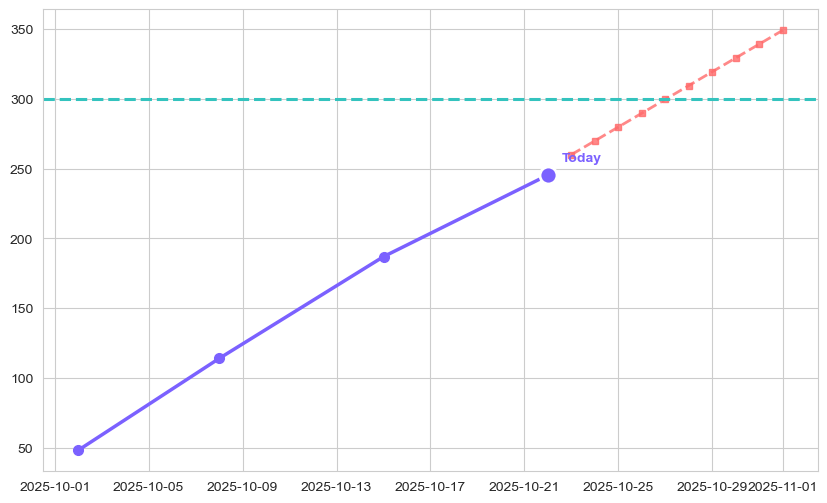

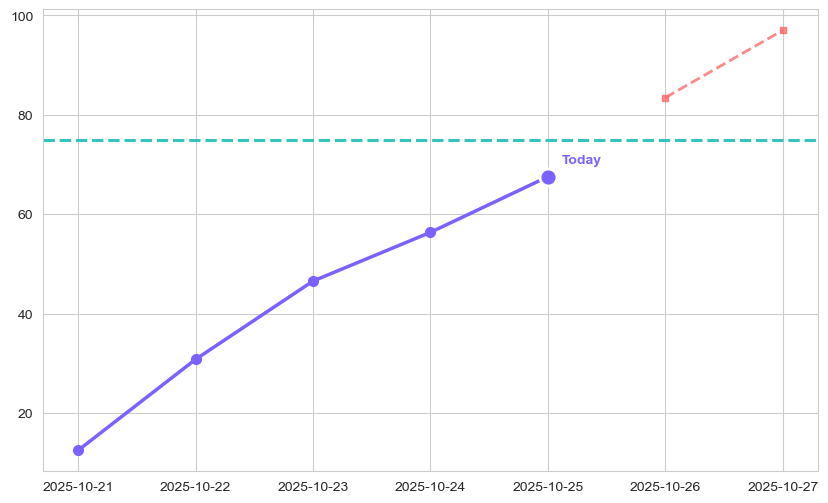

In [4]:
# ---------- EXAMPLES ----------

# timeframe is automatic
forecast_budget(1, plot=True)  # monthly budget test
forecast_budget(8, plot=True)  # weekly budget test